# ICS 471-Deep Learning using Keras-Session 03

We will cover how to develop real-world deep learning models using Keras.

Today, we will go deeper into keras and see how to do the following:


*  Read data from folders using its path stored in Excel file
*  Transfer Learning









### Dataset Reading

This tutorial uses a [dataset](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz) of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
dataset/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

If the data is already downloaded and uploaded to Google Drive, we need to add these lines of code to give Colab authority to access them.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After reaching to the data, we can count the number of images. 


In [ ]:
import glob
experiment_dir = '/content/gdrive/My Drive/Colab Notebooks/ICS471-Keras'
image_count = len(glob.glob(experiment_dir+'/dataset/*/*.jpg'))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

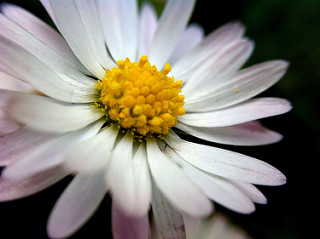

In [ ]:
import PIL
import PIL.Image
daisy = list(glob.glob(experiment_dir+'/dataset/daisy/*'))
PIL.Image.open(str(daisy[0]))

## Load data using a Keras utility

Let's load these images from the disk. There are several methods to read the data from the disk. In this session, we will read the data base on their paths stored in csv file: .

1.   Using the helpful `ImageDataGenerator.flow_from_directory` utility (covered last session)
2.   Using the helpful `ImageDataGenerator.flow_from_dataframe` utility to read the data based on csv (or Excel) file.



### Create a dataset and Data augmentation
In this part, we will create `ImageDataGenerator` for data augmentation, then we will read the data using `ImageDataGenerator.flow_from_dataframe`:


In [ ]:
#Define some parameters for the loader
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.utils import shuffle

# ImageDataGenrator used for split data and perform data augmentation
datagen_train = ImageDataGenerator(rotation_range=40,
        horizontal_flip=True,
        fill_mode='nearest', validation_split=0.2)

datagen_test = ImageDataGenerator()


train_path ='/content/gdrive/My Drive/Colab Notebooks/ICS471-Keras/train.csv'

train_df = pd.read_csv(train_path,names=['label','sPath'],header=None, dtype=str)
train_df = shuffle(train_df)
#change images path to the new path in Google Drive
train_df["sPath"] = experiment_dir + train_df.sPath  


print(train_df)
print(train_df.label)

test_path ='/content/gdrive/My Drive/Colab Notebooks/ICS471-Keras/test.csv'
test_df = pd.read_csv(test_path,names=['label','sPath'],header=None, dtype=str)
#change images path to the new path in Google Drive
test_df["sPath"] = experiment_dir + test_df.sPath   

train_ds = datagen_train.flow_from_dataframe(dataframe=train_df, directory=None, x_col="sPath", y_col="label", batch_size=64, class_mode='categorical', subset = "training", target_size=(img_width, img_height), shuffle=True, seed=42)
val_ds  = datagen_train.flow_from_dataframe(dataframe=train_df,  directory=None, x_col="sPath", y_col="label", batch_size=64, class_mode='categorical', subset = "validation", target_size=(img_width, img_height), shuffle=True, seed=42)
test_ds = datagen_test.flow_from_dataframe(dataframe=test_df,  directory=None, x_col="sPath", y_col="label", batch_size=64, class_mode='categorical', target_size=(img_width, img_height), shuffle=False)

#To know number of samples per set use: train_ds.n

 

           label                                              sPath
1236       roses  /content/gdrive/My Drive/Colab Notebooks/ICS47...
1158   dandelion  /content/gdrive/My Drive/Colab Notebooks/ICS47...
2339      tulips  /content/gdrive/My Drive/Colab Notebooks/ICS47...
2086  sunflowers  /content/gdrive/My Drive/Colab Notebooks/ICS47...
2092  sunflowers  /content/gdrive/My Drive/Colab Notebooks/ICS47...
...          ...                                                ...
1725  sunflowers  /content/gdrive/My Drive/Colab Notebooks/ICS47...
1730  sunflowers  /content/gdrive/My Drive/Colab Notebooks/ICS47...
186        daisy  /content/gdrive/My Drive/Colab Notebooks/ICS47...
221        daisy  /content/gdrive/My Drive/Colab Notebooks/ICS47...
35         daisy  /content/gdrive/My Drive/Colab Notebooks/ICS47...

[2917 rows x 2 columns]
1236         roses
1158     dandelion
2339        tulips
2086    sunflowers
2092    sunflowers
           ...    
1725    sunflowers
1730    sunflowers
186    

### Visualize the data

Here are the first nine images from the training dataset.

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


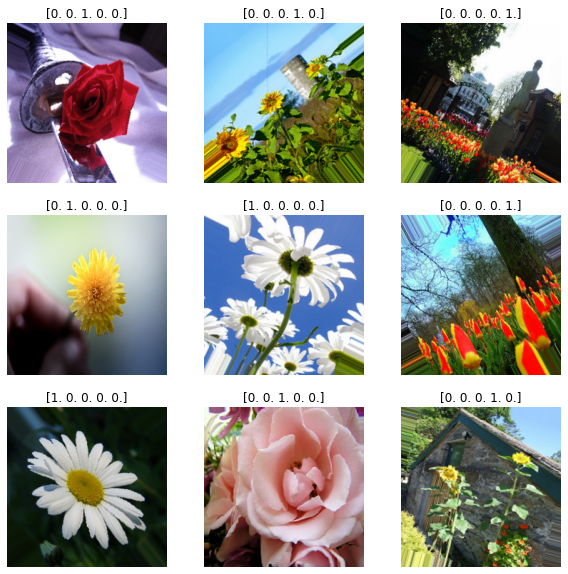

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



plt.figure(figsize=(10, 10))
images, labels = next(train_ds)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i,:,:,:].astype("uint8"))
  plt.title(labels[i])
  plt.axis("off")




You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
x, y = next(train_ds)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64, 5)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

## Building models with the Keras Functional API

After defining your input(s), you can chain layer transformations on top of your inputs,
 until your final output:

In [ ]:
import keras
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, Input
from keras.applications.mobilenet import preprocess_input

def transfer_learning():
   
  input_img = Input(shape=(224, 224, 3))

  input_img = preprocess_input(input_img)

  model_cnn = keras.applications.MobileNet(weights="imagenet", include_top=False, input_tensor=input_img)

  # retrain last four layers
  for layer in model_cnn.layers[:-4]:
       layer.trainable = True

  cnn_out = GlobalAveragePooling2D()(model_cnn.output)
  cnn_out = Dropout(0.5)(cnn_out)

  cnn_out = Dense(5, activation="softmax")(cnn_out)
  model = keras.models.Model(model_cnn.input, cnn_out)

  return model

In [ ]:
myModel = transfer_learning()


In [ ]:
# Let's check out what the model summary looks like:
myModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                           

You can also plot the model as a graph:

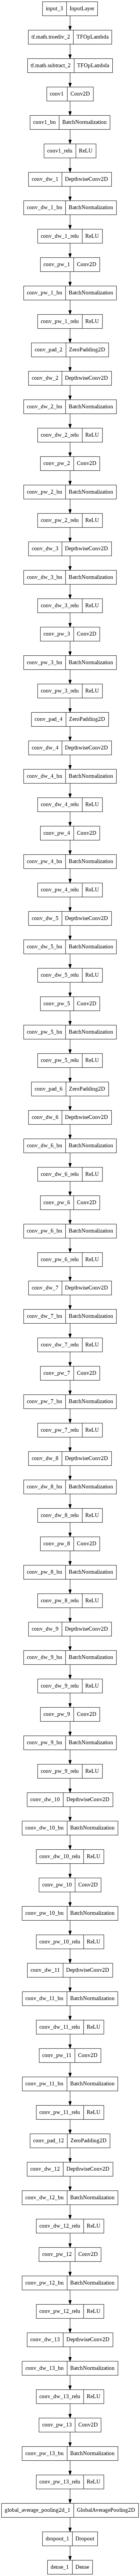

In [ ]:
import tensorflow.keras.utils as utils
utils.plot_model(myModel, "my_first_model.png")

And, optionally, display the input and output shapes of each layer in the plotted graph:

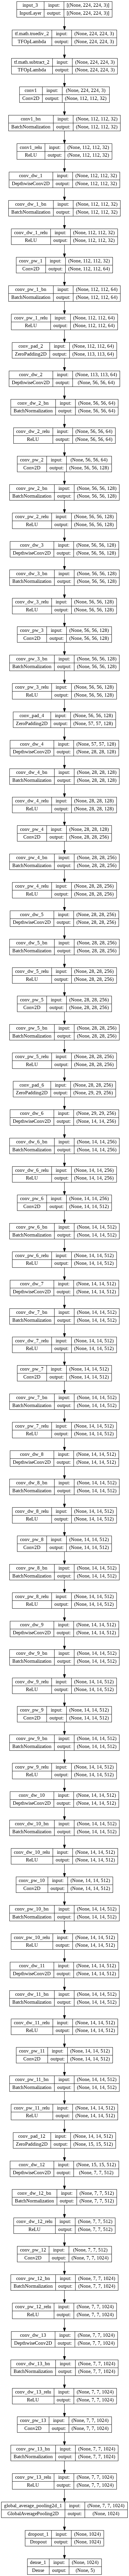

In [ ]:
utils.plot_model(myModel, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam as adam

myModel.compile(optimizer=adam(learning_rate=1e-3),
              loss=tf.losses.categorical_crossentropy, metrics=['accuracy'])

Note: You will only train the model with Early stopping technique and we will save the best model (lowest validation accuracy) in the experiment folder.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
#chkPoints = ModelCheckpoint(filepath='path/to/my/model_{epoch}', save_freq='epoch') # all models will be saved

chkPoints = ModelCheckpoint(filepath=experiment_dir+'/best_model.h5',verbose = 1, save_best_only = True) #save only best model

modelHistory = myModel.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=[early_stopping, chkPoints])


Epoch 1/1000
37/37 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.7905 
Epoch 1: val_loss improved from inf to 4.95131, saving model to /content/gdrive/My Drive/Colab Notebooks/ICS471-Keras/best_model.h5
37/37 [==============================] - 528s 14s/step - loss: 0.7179 - accuracy: 0.7905 - val_loss: 4.9513 - val_accuracy: 0.5660
Epoch 2/1000
37/37 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8907
Epoch 2: val_loss improved from 4.95131 to 2.82369, saving model to /content/gdrive/My Drive/Colab Notebooks/ICS471-Keras/best_model.h5
37/37 [==============================] - 50s 1s/step - loss: 0.3187 - accuracy: 0.8907 - val_loss: 2.8237 - val_accuracy: 0.6484
Epoch 3/1000
37/37 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9276
Epoch 3: val_loss improved from 2.82369 to 2.46207, saving model to /content/gdrive/My Drive/Colab Notebooks/ICS471-Keras/best_model.h5
37/37 [==============================] - 51s 1s

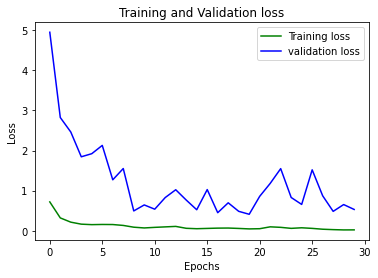

In [ ]:
loss_train = modelHistory.history['loss']
loss_val = modelHistory.history['val_loss']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


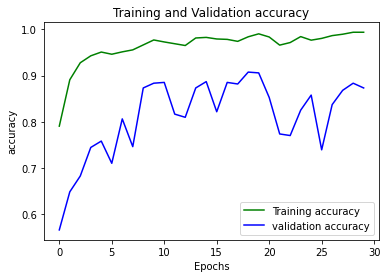

In [ ]:
acc_train = modelHistory.history['accuracy']
acc_val = modelHistory.history['val_accuracy']
epochs = range(len(acc_train))
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [ ]:
model = tf.keras.models.load_model(experiment_dir+'/best_model.h5')

loss, acc = model.evaluate(test_ds)
print("Testing accuracy is: ", acc)

12/12 [==============================] - 135s 12s/step - loss: 0.4984 - accuracy: 0.9124
Testing accuracy is:  0.912350594997406
